<a href="https://colab.research.google.com/github/bmil-ssu/advanced_ann/blob/main/2024/Code/Advanced_ann_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch [1/50], Loss: 0.1025
Epoch [2/50], Loss: 0.0686
Epoch [3/50], Loss: 0.0559
Epoch [4/50], Loss: 0.0456
Epoch [5/50], Loss: 0.0392
Epoch [6/50], Loss: 0.0347
Epoch [7/50], Loss: 0.0316
Epoch [8/50], Loss: 0.0290
Epoch [9/50], Loss: 0.0272
Epoch [10/50], Loss: 0.0257
Epoch [11/50], Loss: 0.0247
Epoch [12/50], Loss: 0.0239
Epoch [13/50], Loss: 0.0231
Epoch [14/50], Loss: 0.0224
Epoch [15/50], Loss: 0.0218
Epoch [16/50], Loss: 0.0212
Epoch [17/50], Loss: 0.0208
Epoch [18/50], Loss: 0.0203
Epoch [19/50], Loss: 0.0198
Epoch [20/50], Loss: 0.0194
Epoch [21/50], Loss: 0.0190
Epoch [22/50], Loss: 0.0186
Epoch [23/50], Loss: 0.0182
Epoch [24/50], Loss: 0.0177
Epoch [25/50], Loss: 0.0173
Epoch [26/50], Loss: 0.0170
Epoch [27/50], Loss: 0.0166
Epoch [28/50], Loss: 0.0163
Epoch [29/50], Loss: 0.0160
Epoch [30/50], Loss: 0.0157
Epoch [31/50], Loss: 0.0154
Epoch [32/50], Loss: 0.0151
Epoch [33/50], Loss: 0.0149
Epoch [34/50], Loss: 0.0147
Epoch [35/50], Loss: 0.0146
Epoch [36/50], Loss: 0.0143
E

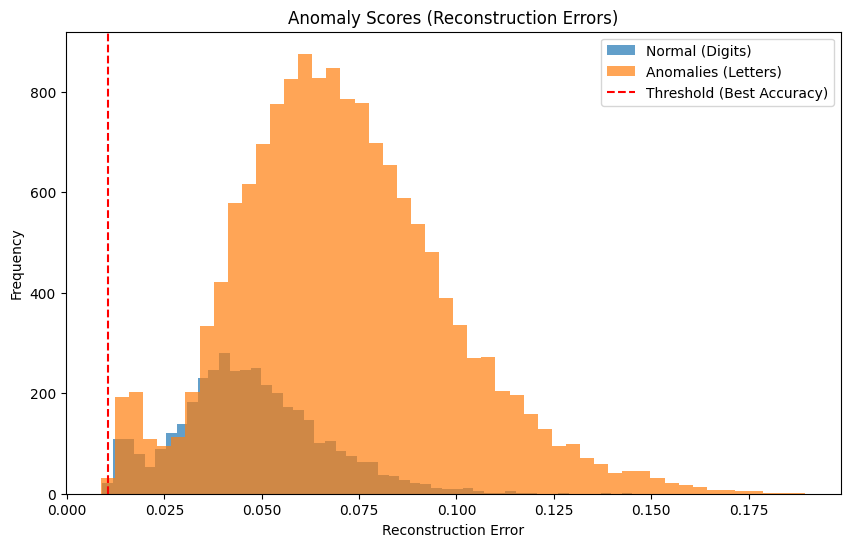

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt

# EMNIST 데이터를 Kaggle에서 다운로드한 후 'emnist-digits-train.csv' 및 'emnist-digits-test.csv'를 불러옵니다
train_data = pd.read_csv('emnist-balanced-train.csv', header=None)
test_data = pd.read_csv('emnist-balanced-test.csv', header=None)

# 데이터 전처리
X_train = train_data.iloc[:, 1:].values.astype('float32') / 255.
y_train = train_data.iloc[:, 0].values
X_test = test_data.iloc[:, 1:].values.astype('float32') / 255.
y_test = test_data.iloc[:, 0].values

# 28x28 이미지를 1차원 벡터로 변환
X_train = X_train.reshape((X_train.shape[0], 784))
X_test = X_test.reshape((X_test.shape[0], 784))

# 숫자 데이터(라벨 0-9)와 문자 데이터(라벨 10 이상) 분리
X_train_digits = X_train[y_train < 10]  # 숫자 데이터만 학습
X_test_digits = X_test[y_test < 10]  # 테스트 정상(숫자)
X_test_letters = X_test[y_test >= 10]  # 테스트 비정상(문자)

# PyTorch 데이터셋 및 DataLoader 생성
train_dataset = TensorDataset(torch.tensor(X_train_digits), torch.tensor(X_train_digits))
test_digits_dataset = TensorDataset(torch.tensor(X_test_digits), torch.zeros(X_test_digits.shape[0]))
test_letters_dataset = TensorDataset(torch.tensor(X_test_letters), torch.ones(X_test_letters.shape[0]))

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_digits_loader = DataLoader(test_digits_dataset, batch_size=256)
test_letters_loader = DataLoader(test_letters_dataset, batch_size=256)

# Autoencoder 모델 정의
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 784),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# 모델, 손실 함수, 옵티마이저 정의
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Autoencoder 학습
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for data, _ in train_loader:
        data = data.to(device)

        # 순전파
        outputs = model(data)
        loss = criterion(outputs, data)

        # 역전파 및 최적화
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

# 정상(숫자)과 비정상(문자) 데이터 결합
X_test_combined = np.concatenate([X_test_digits, X_test_letters], axis=0)
y_test_combined = np.concatenate([np.zeros(len(X_test_digits)), np.ones(len(X_test_letters))], axis=0)

# PyTorch 텐서로 변환
X_test_combined_tensor = torch.tensor(X_test_combined).to(device)

# Autoencoder를 사용한 테스트 데이터 재구성 및 재구성 오차 계산
model.eval()
with torch.no_grad():
    reconstructed = model(X_test_combined_tensor).cpu().numpy()

reconstruction_error = np.mean(np.abs(reconstructed - X_test_combined), axis=1)

# 다양한 threshold를 시도하여 accuracy가 최대가 되는 임계값 찾기
best_threshold = 0
best_accuracy = 0
best_y_pred = None

thresholds = np.linspace(np.min(reconstruction_error), np.max(reconstruction_error), 100)
accuracies = []

for threshold in thresholds:
    y_pred = (reconstruction_error > threshold).astype(int)
    acc = accuracy_score(y_test_combined, y_pred)
    accuracies.append(acc)

    if acc > best_accuracy:
        best_accuracy = acc
        best_threshold = threshold
        best_y_pred = y_pred

print(f"Best Threshold: {best_threshold:.4f}, Best Accuracy: {best_accuracy:.4f}")

# 성능 평가 (최적 threshold 기준)
precision = precision_score(y_test_combined, best_y_pred)
recall = recall_score(y_test_combined, best_y_pred)
f1 = f1_score(y_test_combined, best_y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Anomaly Score (재구성 오차) 그래프 시각화
plt.figure(figsize=(10, 6))
plt.hist(reconstruction_error[y_test_combined == 0], bins=50, alpha=0.7, label='Normal (Digits)')
plt.hist(reconstruction_error[y_test_combined == 1], bins=50, alpha=0.7, label='Anomalies (Letters)')
plt.axvline(best_threshold, color='r', linestyle='--', label=f'Threshold (Best Accuracy)')
plt.title('Anomaly Scores (Reconstruction Errors)')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()
